In [1]:
import sys
from pathlib import Path

sys.path.append(str(Path.cwd().parent))
project_root = Path.cwd().parent

In [2]:
import numpy as np
import pandas as pd
import ast
import matplotlib.pyplot as plt
from scipy.special import gammaln
from scipy.stats import poisson, nbinom
from tqdm import tqdm
import openpyxl
import particles
import particles.state_space_models as ssm
import particles.distributions as dists


# local files
import src.cox_simulation as cx
import utils.plots as pl
import src.creal_filter as cf 
import src.particle_filter as pf
import utils.load_data as ld

In [3]:
excel_path = project_root / "data" / "data_groupe_T1000.xlsx"
if not excel_path.exists():
    raise FileNotFoundError(f"File not found: {excel_path}")

In [4]:
# --- CONFIGURATION GLOBALE ---
T_COMMON = 1000
GLOBAL_SEED = 42

export_data = {}

# ==============================================================================
# SÉRIE 1 : Sans covariables (Phi=0.965)
# ==============================================================================
params_1 = {"phi": 0.965, "nu": 2.5, "c": 0.2}

sim1 = cx.CoxProcessSimulation(T=T_COMMON, **params_1, seed=1)
y0, h0, z0 = sim1.simulate(init="stationary")

export_data["Serie_1"] = {
    "params": str(params_1), 
    "beta": "None",
    "df": pd.DataFrame({"y": y0, "h_true": h0})
}
print(" Série 1 générée.")

 Série 1 générée.


In [5]:
# ==============================================================================
# SÉRIE 2 : 1 Covariable (Bruit Blanc) + Intercept
# ==============================================================================
params_2 = {"phi": 0.8, "nu": 3, "c": 0.4}
rng = np.random.default_rng(2) # Seed spécifique pour les covariables

X1 = np.column_stack([
    np.ones(T_COMMON),    # Intercept
    rng.normal(size=T_COMMON) # Covariable 1
])
beta1 = np.array([-0.5, 0.3])
tau1 = np.ones(T_COMMON)

sim2 = cx.CoxProcessSimulation(T=T_COMMON, **params_2, seed=2)

y1, h1, z1, expo1 = sim2.simulate(X=X1, beta=beta1, tau=tau1, return_exposure=True)

df2 = pd.DataFrame({"y": y1, "h_true": h1})

df2["X_intercept"] = X1[:, 0]
df2["X_cov1"] = X1[:, 1]

export_data["Serie_2"] = {
    "params": str(params_2),
    "beta": str(list(beta1)),
    "df": df2
}
print(" Série 2 générée.")


 Série 2 générée.


In [6]:
# ==============================================================================
# SÉRIE 3 : 2 Covariables (Bruit Blanc + AR1) + Intercept
# ==============================================================================
params_3 = {"phi": 0.8, "nu": 2.5, "c": 0.2}
rng = np.random.default_rng(3)

# Construction AR(1) manuelle
x_ar = np.zeros(T_COMMON)
for t in range(1, T_COMMON):
    x_ar[t] = 0.8 * x_ar[t - 1] + rng.normal()

X2 = np.column_stack([
    np.ones(T_COMMON),    
    rng.normal(size=T_COMMON), # Covariable 1
    x_ar                  # Covariable 2 (AR1)
])
beta2 = np.array([-0.5, 0.4, -0.3])
tau2 = np.ones(T_COMMON)

sim3 = cx.CoxProcessSimulation(T=T_COMMON, **params_3, seed=3)
y2, h2, z2, expo2 = sim3.simulate(X=X2, beta=beta2, tau=tau2, return_exposure=True)

df3 = pd.DataFrame({"y": y2, "h_true": h2})
df3["X_intercept"] = X2[:, 0]
df3["X_cov1"] = X2[:, 1]
df3["X_cov2"] = X2[:, 2]

export_data["Serie_3"] = {
    "params": str(params_3),
    "beta": str(list(beta2)),
    "df": df3
}
print(" Série 3 générée.")



 Série 3 générée.


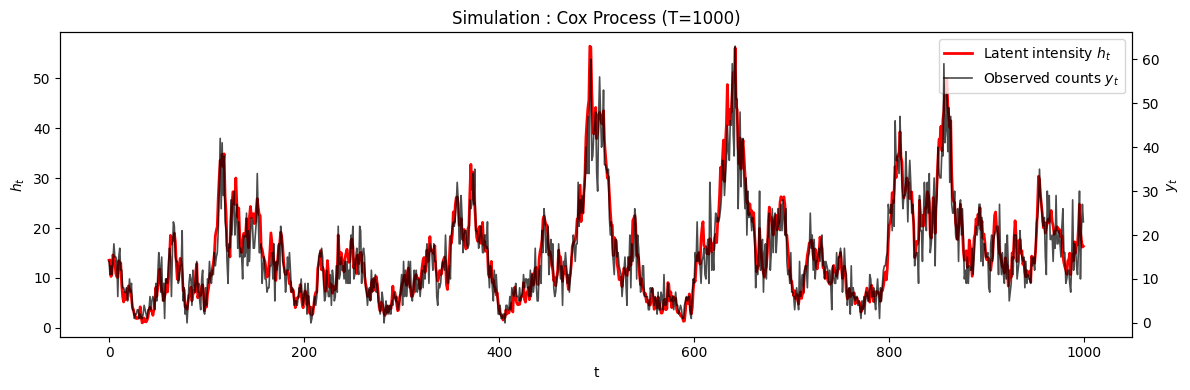

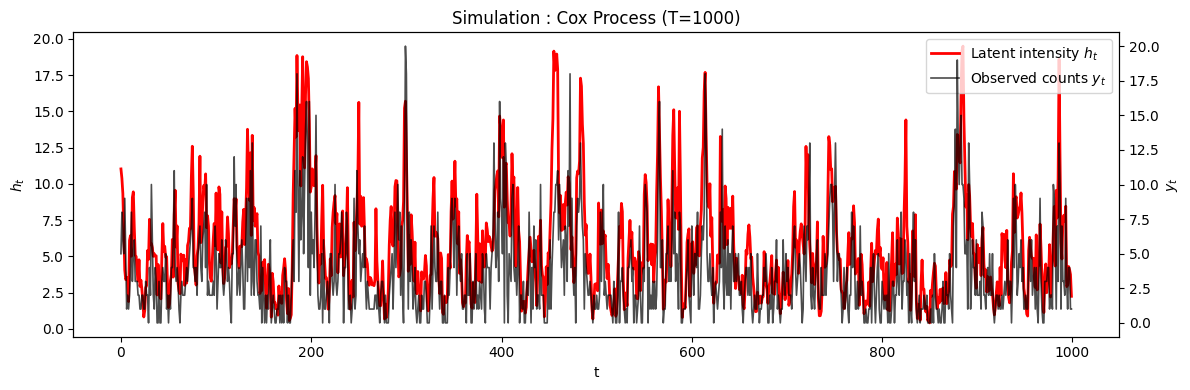

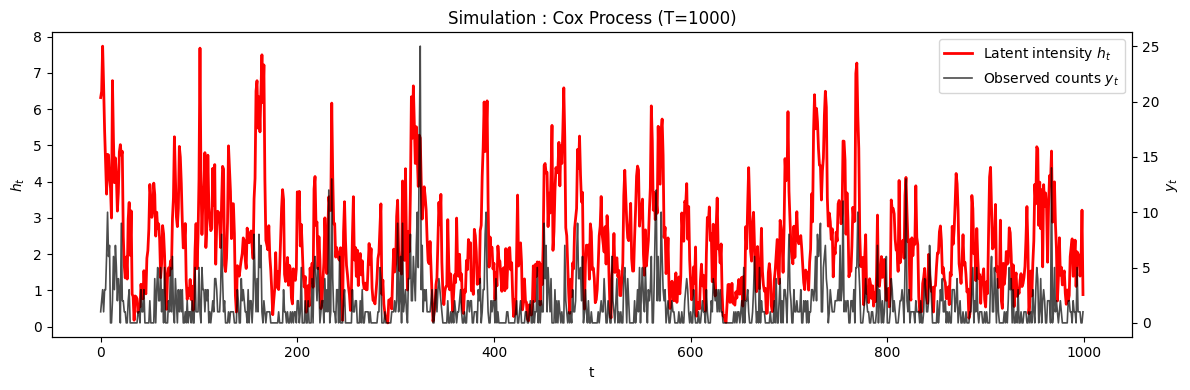

In [7]:
pl.plot_overlay_clean(y0, h0, T_show=1000, start=0)
pl.plot_overlay_clean(y1, h1, T_show=1000, start=0)
pl.plot_overlay_clean(y2, h2, T_show=1000, start=0)

 Load: Serie_1 (Beta: None)


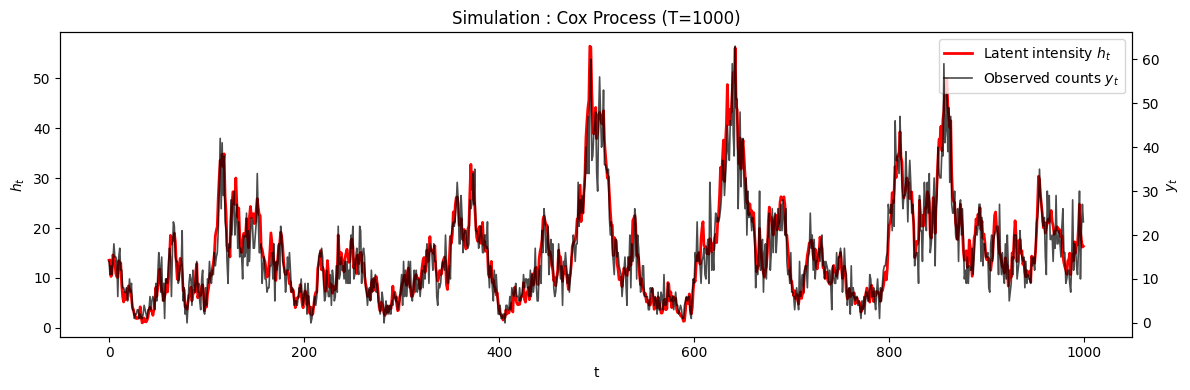

In [8]:
y1, X1, h1, beta1, p1 = ld.load_data(excel_path, "Serie_1")
pl.plot_overlay_clean(y1, h1, T_show=1000, start=0)

 Load: Serie_2 (Beta: [-0.5  0.3])


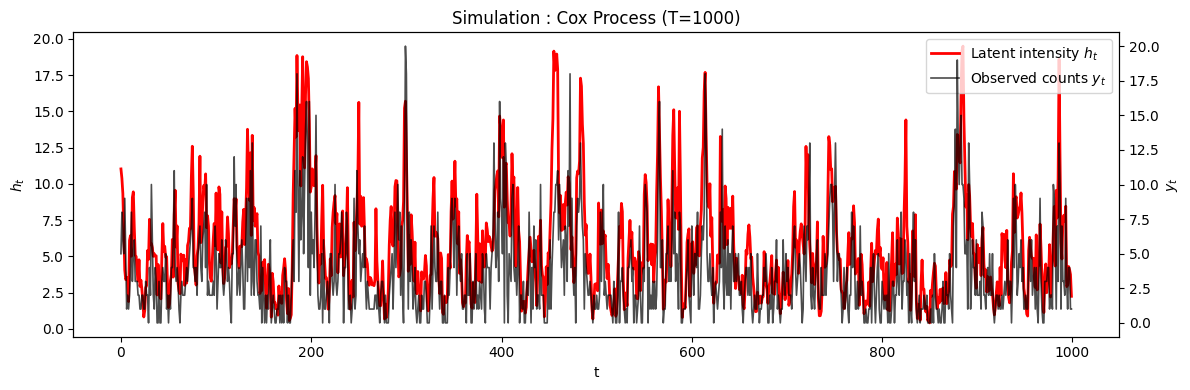

In [9]:
y2, X2, h2, beta2, p2 = ld.load_data(excel_path, "Serie_2")
pl.plot_overlay_clean(y2, h2, T_show=1000, start=0)

 Load: Serie_3 (Beta: [-0.5  0.4 -0.3])


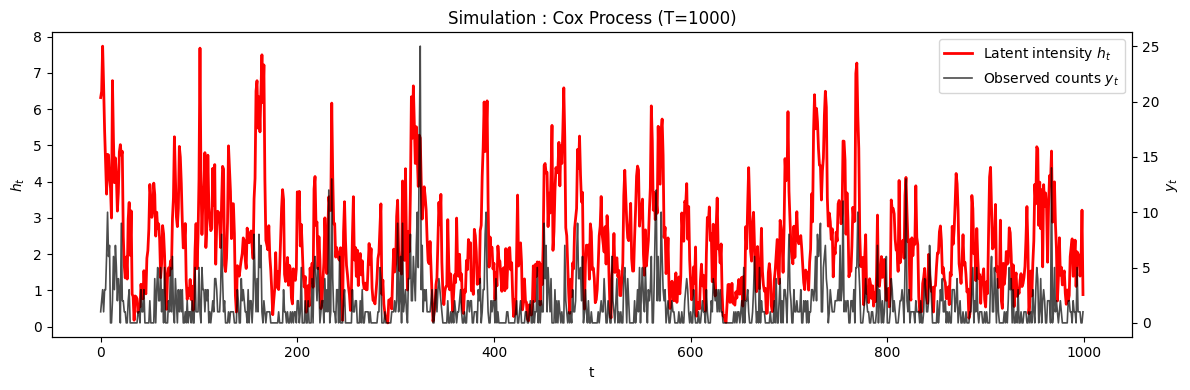

In [10]:
y3, X3, h3, beta3, p3 = ld.load_data(excel_path, "Serie_3")
pl.plot_overlay_clean(y3, h3, T_show=1000, start=0)
